# 2022-08-21 • Area under STA (new conntest)

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

[ Info: Precompiling VoltoMapSim [f713100b-c48c-421a-b480-5fcb4c589a9e]


## Params

Based on Roxin; same as previous nb's.

In [5]:
d = 6
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1, 801],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment_simdata(s, p);

## New connection test statistic

In [8]:
ii = s.input_info[1];

In [76]:
using PyPlot

[ Info: Precompiling Sciplotlib [61be95e5-9550-4d5f-a203-92a5acbc3116]


In [77]:
using VoltoMapSim.Plot

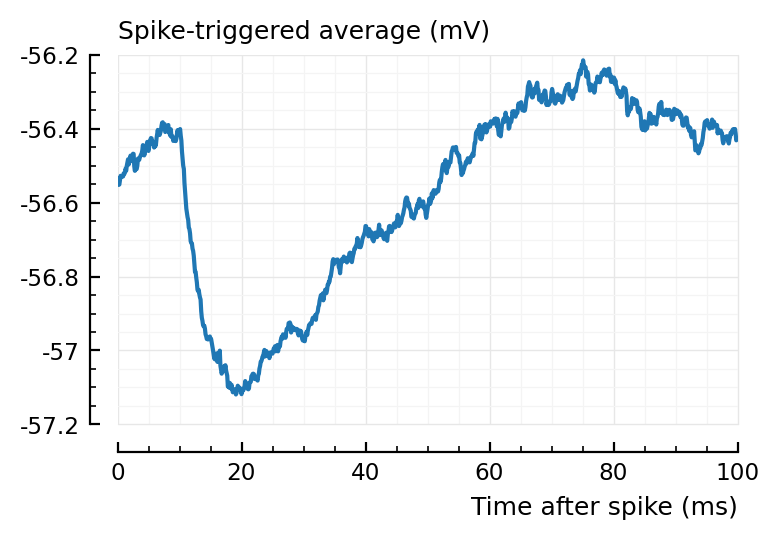

In [26]:
plotSTA(ii.v, ii.spiketrains.conn.inh[1], p);

In [28]:
sta = calc_STA(ii.v, ii.spiketrains.conn.inh[1], p);

In [34]:
t = sum(sta .- sta[1]);

What are the units? Sum of: voltage * dt.  
So units are volt·second. But I'd had to add the dt to every term.
I can do afterwards.

In [35]:
dt = p.sim.general.Δt;

In [38]:
t * dt / (mV * ms)

-3.55

(Estimate from graph for how big this should be: approx 0.5 mV difference, times 40 ms or so.
So 20 mV·ms. Sure).
How much is above and below?

In [41]:
sig = (sta .- sta[1]) * dt / (mV*ms)
above = sum(sig[sig .> 0])
below = sum(sig[sig .< 0])
above, below

(9, -12.5)

Nice, so yes units seem right.

How to name this measure.
It's area under STA, referenced to STA at t=0.
AUS? AUA?
relsum?  
Area over start.  
Just `area` is quite nice.

Adding this to `misc.jl`:

In [68]:
area(STA) = sum(STA .- STA[1]);

## Compare performance
..between test measures: existing (peak-to-peak) and the new.

In [49]:
p0 = p;
pn = (@set p.conntest.STA_test_statistic = "area");

In [62]:
cached_conntest_perf = VoltoMapSim.cached_conntest_perf;

In [72]:
perf0 = cached_conntest_perf(1, ii.v, ii.spiketrains, p0);

In [73]:
perf0.detection_rates

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

In [74]:
perfn = cached_conntest_perf(1, ii.v, ii.spiketrains, pn);

Testing connections: 100%|██████████████████████████████| Time: 0:00:24
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\51a268c55a44be7a.jld2` … done (4.5 s)


In [75]:
perfn.detection_rates

(TPR_exc = 0, TPR_inh = 0.8, FPR = 0.175)

Aha! It seems significantly worse than peak-to-peak (for this sim, this neuron).

Thing left to do is, use this to determine whether a presynaptic neuron is excitatory or inhibitory (now we're cheating and presupposing that knowledge in the conntest perf eval).

I think it's gonna make the performance way worse.

First, let's redo the test for the inhibitory recorded neuron.

In [79]:
ii_inh = s.input_info[801];

In [80]:
perf0 = cached_conntest_perf(801, ii_inh.v, ii_inh.spiketrains, p0);

Testing connections: 100%|██████████████████████████████| Time: 0:00:20
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\6a503ee8521e347c.jld2` … done


In [81]:
perf0.detection_rates

(TPR_exc = 0.714, TPR_inh = 0.9, FPR = 0.05)

In [82]:
perfn = cached_conntest_perf(801, ii_inh.v, ii_inh.spiketrains, pn);

Testing connections: 100%|██████████████████████████████| Time: 0:00:21
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf\352d0f0ba159fa0b.jld2` … done


In [84]:
perfn.detection_rates

(TPR_exc = 0.381, TPR_inh = 0.7, FPR = 0.1)

Again, signifcantly worse performance.

## Use `area` for deciding exc or inh

This was the original motivation for this measure.

Our current `test_connection` returns a p-value based on peak-to-peak. It only says _whether_ it thinks the presynaptic neuron is connected, not what type it is.
We'll add the `area` for that:

In [34]:
function test_connection_and_type(v, spikes, p)
    pval = test_connection(v, spikes, p)
    dt = p.sim.general.Δt
    A = area(calc_STA(v, spikes, p)) * dt / (mV*ms)
    if pval ≥ p.evaluation.α
        predicted_type = :unconn
    elseif A > 0
        predicted_type = :exc
    else
        predicted_type = :inh
    end
    return (; predicted_type, pval, area_over_start=A)
end;

In [106]:
test_connection_and_type(ii.v, ii.spiketrains.conn.inh[1], p)

(predicted_type = :inh, pval = 0.01, area_over_start = -3.55)

### Performance optimization sidebar

In [51]:
@time test_connection_and_type(ii.v, ii.spiketrains.conn.inh[1], p)

  0.853824 seconds (1.35 k allocations: 22.599 MiB)


(predicted_type = :inh, pval = 0.01, area = -3.55)

Sidenote, shuffle connection test takes a while. Profiling shows that almost all time is spent in the `calc_STA` addition loop.
```julia
STA .+= @view VI_sig[a:b]
```
Doesn't seem much more optimizable.

Wait, that broadcasting `.` is not necessary. Let's see what perf is without.

In [36]:
@time test_connection_and_type(ii.v, ii.spiketrains.conn.inh[1], p)

  5.284591 seconds (720.96 k allocations: 5.469 GiB, 20.00% gc time)


(predicted_type = :inh, pval = 0.01, area = -3.55)

Huh, perf is worse with it, and way more allocations. Weird. Revert.

Trying with manual for loop (and `@inbounds`):

[..]

this made a type instability problem apparent (manual loop super slow. → `@code_warntype`. much red. problem was that Δt not inferred (cause simtype abstract). manually adding type made manual loop fast; and the prev, non manual loop also faster :))

Yes good, the new profile now also shows that the majority of time is spent in `float:+`, as it should be.

Now testing whether sim itself suffers from this same type instability problem..

In [ ]:
# pshort = (@set p.sim.general.duration = 1*seconds);
# @code_warntype VoltoMapSim.init_sim(pshort.sim);
# state = VoltoMapSim.init_sim(pshort.sim);
#@code_warntype VoltoMapSim.step_sim!(state, pshort.sim, 1);

It doesn't. Type known-ness ("stability") seems good enough.

---

### Back on topic

Now use the new `test_connection_and_type` in a reworked `eval_conntest_perf` function:

In [14]:
using DataFrames

In [65]:
# @cached key=[:m,:p] (
function evaluate_conntest_perf_v2(s, m, p)
    # s = augmented simdata
    # m = postsynaptic neuron ID
    @unpack N_tested_presyn, rngseed = p.evaluation;
    resetrng!(rngseed)
    function get_IDs_labels(IDs, label)
        N = min(length(IDs), N_tested_presyn)
        IDs_sample = sample(IDs, N, replace = false, ordered = true)
        return zip(IDs_sample, fill(label, N))
    end
    ii = s.input_info[m]
    IDs_labels = chain(
        get_IDs_labels(ii.exc_inputs, :exc),
        get_IDs_labels(ii.inh_inputs, :inh),
        get_IDs_labels(ii.unconnected_neurons, :unconn),
    )
    tested_neurons = DataFrame(
        input_neuron_ID = Int[],     # global ID
        real_type       = Symbol[],  # :unconn, :exc, :inh
        predicted_type  = Symbol[],  # idem
        pval            = Float64[],
        area_over_start = Float64[],
    )
    @showprogress (every = 400ms) "Testing connections: " (
    for (n, label) in collect(IDs_labels)  # `collect` necessary somehow
        test_result = test_connection_and_type(ii.v, s.spike_times[n], p)
        row = (input_neuron_ID = n, real_type = label, test_result...)
        push!(tested_neurons, Dict(pairs(row)))
    end)
    tn = tested_neurons
    det_rate(t) = count((tn.real_type .== t) .& (tn.predicted_type .== t)) / count(tn.real_type .== t)    
    detection_rates = (
        TPR_exc = det_rate(:exc),
        TPR_inh = det_rate(:inh),
        FPR = 1 - det_rate(:unconn),
    )
    return (; tested_neurons, detection_rates)
end
# end)

cached_eval(s, m, p) = cached(evaluate_conntest_perf_v2, [s, m, p], key = [m, p]);

Aside: @cached macro wish.  
Also generates a $(funcname)_uncached.
So here: evaluate_conntest_perf_uncached

In [68]:
# @profview evaluate_conntest_perf_v2(s, 1, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:32


^ Most time spent in the `+` and the `setindex` of the `calc_STA` loop.
(A bit also in `shuffle_ISIs`).
(Could speed up a bit maybe by having STA on the stack -- prob using StaticArrays.jl -- to save that `setindex` time.
Though wouldn't be major, as most time is still spent in float `+`). Another thing to try is `@fastmath` IEEE rules relaxing, to speed up the `+`.

In [66]:
testeval = cached_eval(s, 1, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:25
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf_v2\b8c53748899be8e2.jld2` … done (6.9 s)


In [70]:
ENV["LINES"] = 100

100

In [72]:
testeval.detection_rates

(TPR_exc = 0, TPR_inh = 1, FPR = 0.125)

Comparison with before, when we didn't predict the type (just connected or not) (from `2022-07-05__Network-conntest`):

(TPR_exc = 0.154, TPR_inh = 1, FPR = 0.15)

The exc performance drops to zero.
This is because all previously detected exc inputs are still detected, but classified as inhibitory, as seen in the below table.

The FPR rate is different because we now take a random sample of unconnected neurons to test (before, we took the first 40).

In [71]:
testeval.tested_neurons

,input_neuron_ID,real_type,predicted_type,pval,area_over_start
,Int64,Symbol,Symbol,Float64,Float64
1,312,exc,unconn,0.51,11.3
2,565,exc,unconn,0.61,7.25
3,681,exc,unconn,0.55,6.58
4,597,exc,inh,0.02,-37.9
5,447,exc,unconn,0.68,1.42
6,766,exc,unconn,0.46,-7.55
7,132,exc,unconn,0.54,-20.9
8,139,exc,unconn,0.91,-22.8
9,446,exc,unconn,0.34,-27.5


### Inhibitory postsynaptic neuron

Now test input connections to the recorded inhibitory neuron:

In [73]:
te_inh = cached_eval(s, 801, p);

Testing connections: 100%|██████████████████████████████| Time: 0:00:21
Saving output at `C:\Users\tfiers\.phdcache\datamodel v2 (net)\evaluate_conntest_perf_v2\e828a750d5830742.jld2` … done


In [74]:
te_inh.detection_rates

(TPR_exc = 0.619, TPR_inh = 0.8, FPR = 0.075)

Comparison with before, as above:

`(TPR_exc = 0.714, TPR_inh = 0.9, FPR = 0.05)`

Results per neuron below.
The `area_over_start` seems to work: exc is mostly positive (and thus predicted as exc), and vice versa for inhibitory/negative.

In [75]:
te_inh.tested_neurons

,input_neuron_ID,real_type,predicted_type,pval,area_over_start
,Int64,Symbol,Symbol,Float64,Float64
1,544,exc,exc,0.01,156
2,345,exc,exc,0.01,41.6
3,468,exc,exc,0.01,74.1
4,206,exc,exc,0.01,147
5,689,exc,unconn,0.47,16.3
6,251,exc,exc,0.01,87.9
7,67,exc,exc,0.01,37.1
8,540,exc,exc,0.01,0.983
9,331,exc,exc,0.01,70.3


We missclassify an inhibitory input as excitatory because it's "area over start" is positive.
What does the STA look like?

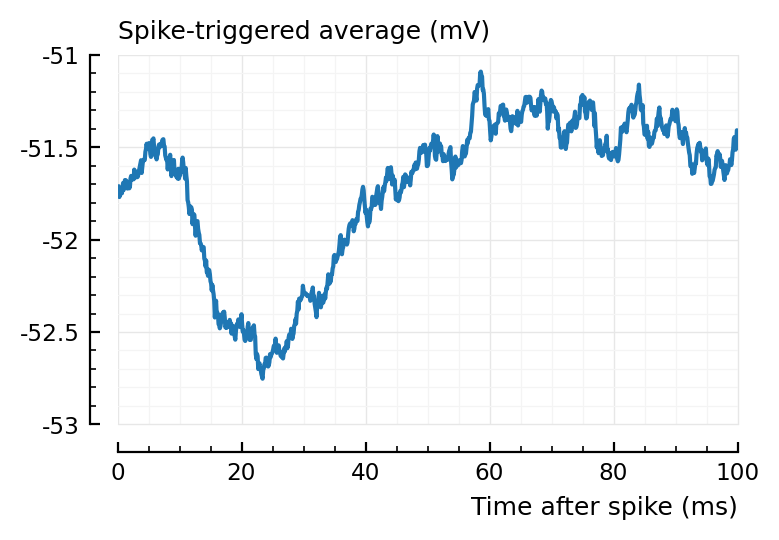

In [79]:
plotSTA(s.signals[801].v, s.spike_times[846], p);

Looks nicely downwards..

In [80]:
area(calc_STA(s.signals[801].v, s.spike_times[846], p))

0.0251

But the area-over-start is indeed positive.

Could be remedied with a shorter STA window length.

For comparison, the STA of a correctly identified inh input:

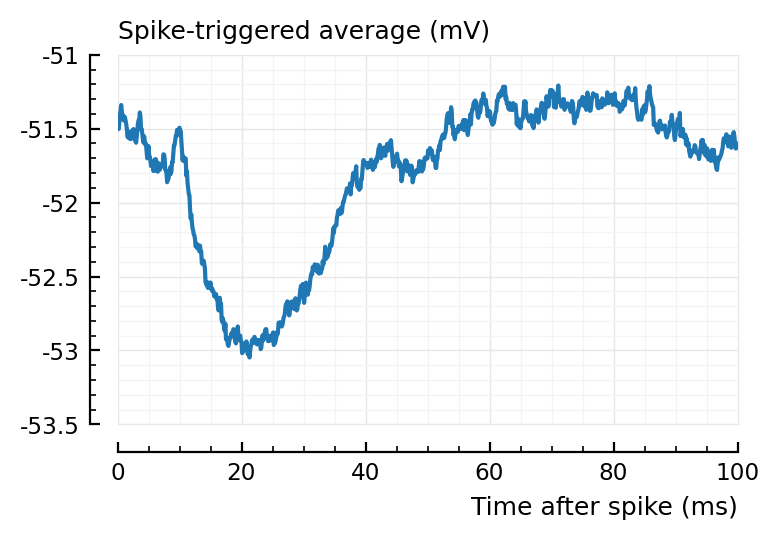

In [81]:
plotSTA(s.signals[801].v, s.spike_times[815], p);

Looks very similar (the relative height of the positive and negative bumps).

The problem (the difference) is at t0.

---
Unrelated question (on previous results):
Why are exc input STA's on inh good, but on exc neurons so bad?